# Spike sorting: Finding the neurons in brain signals

*Introduction to Computational Neuroscience, Charles University, Winter 2024*

*Tutor: Dr. Aitor Morales-Gregorio*

We will analize data where some monkeys were shown a checkerboard in the screen, the visual stimulus is not important this week.

<img src="monkey_diagram.png" alt="monkey_diagram" height="150"/>
<img src="brain_render.png" alt="brain_render" height="150"/>

The data is from [Chen, Morales-Gregorio et al (2022)](https://www.nature.com/articles/s41597-022-01180-1).

We will analyze the data from one electrode, the signal was sampled at 30 kHz, that is **30000 points per second**. 

Each neuron usually has a unique electrical fingerprint, which is repeated every time the same neuron has an action potential. We call this the **neuron waveform**, and it depends on the distance from the electrode to the neuron, as well as the neuron shape and type.

<img src="electrode_and_neurons.png" alt="electrode_and_neurons" height="400"/>

Action potentials are also called **spikes**, and their waveforms usually last only 1 millisecond.

### Getting started

Can you see the spikes?

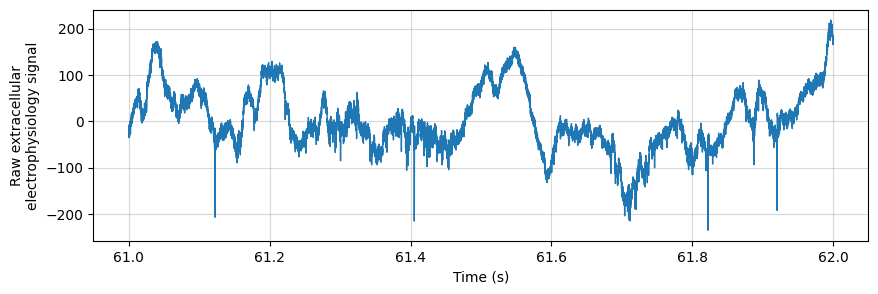

In [1]:
%matplotlib inline
# %matplotlib tk # Uncomment this line to open plots in a new window

import numpy as np
import scipy
import matplotlib.pyplot as plt

# This loads the data you will need
# It is the raw signal from the visual cortex of a macaque monkey at 30 kHz
ephys_signal = np.load('macaqueL_SNR_250717_Channel388.npy')
sampling_rate = 30000

# Here we plot a snippet of data, so you can see how it looks like
plt.figure(figsize=(10, 3))
plt.plot(np.arange(61, 62, step=1/sampling_rate), ephys_signal[int(61*sampling_rate):int(62*sampling_rate)], lw=1)
plt.grid(alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Raw extracellular\nelectrophysiology signal')
plt.show()

### Filtering the signal

Also there is a ton of low frequency oscillations that are making finding the spikes harder. We can solve that with a filter!

NOTE: No filter can make a clean cut in the power spectrum, the best one can do to avoid edge effects (ringing, ripples) is a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter). 

Can you see the spikes now?

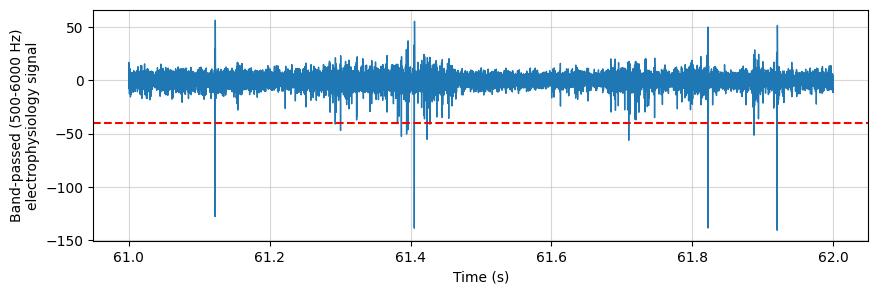

In [2]:
%matplotlib inline

import elephant

# Here we apply a Butterworth filter to the frequencies of the signal
# We take everything above 500 Hz and below 6 kHz
# spikes are known to be in this range, usually at 1 kHz
filtered_signal = elephant.signal_processing.butter(ephys_signal,
                                                    highpass_frequency=500,
                                                    lowpass_frequency=6000,
                                                    sampling_frequency=sampling_rate,
                                                    order=4)

# Here we plot a snippet of data, so you can see how it looks like
plt.figure(figsize=(10, 3))
plt.plot(np.arange(61, 62, step=1/sampling_rate), filtered_signal[int(61*sampling_rate):int(62*sampling_rate)], lw=1)
plt.axhline(y=-40, color='r', linestyle='--')
plt.grid(alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Band-passed (500-6000 Hz)\nelectrophysiology signal')
plt.show()

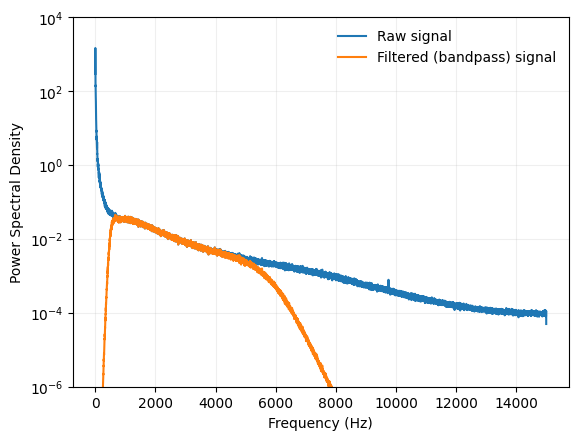

In [3]:
# Calculate the power spectrum of both the unfiltered and the filtered signals
f_raw, psd_raw = scipy.signal.welch(ephys_signal, fs=sampling_rate, nperseg=sampling_rate)
f_filter, psd_filter = scipy.signal.welch(filtered_signal, fs=sampling_rate, nperseg=sampling_rate)

# Plot both power spectra
plt.plot(f_raw, psd_raw, label='Raw signal')
plt.plot(f_filter, psd_filter, label='Filtered (bandpass) signal')

plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.yscale('log')
plt.grid(alpha=0.2)
plt.ylim(1e-6, 1e4)
plt.legend(frameon=False)

# Exercises

### Exercise 1: Find the spike times

Using the filtered signal estimate when spikes are happening in this signal.

HINT: Use a negative threshold of around `threshold = -40` (roughly `-5*np.std(filtered_signal)`), values below this threshold are part of a spike. Determining the threshold is *very strongly debated* by neuroscientists.

WARNING: You only want to record each spike once! If two consecutive bins are below the threshold only the first one should be taken. This can be achieved by looking at when the thresholded signal goes from `False` to `True` by using `np.diff`. Careful not to take also when they go back from `True` to `False`!!


**You should find around 1655 spikes.**


In [ ]:
# Find the spike times
threshold = -40
possible_spikes = np.where(np.diff(filtered_signal < threshold) == 1)[0]
len(possible_spikes)


3310

### Exercise 2: Get the waveforms

Let's get the waveforms for the spikes you just detected!

1. Loop over the spike times, and take 10 points before and 30 points after your detected spike times (40 points at 30 kHz correspond to 1.33 ms)

2. Plot the waveforms all in the same figure (code provided).

3. How many neurons do you see? REMEMBER! A neuron usually has the same waveform when it spikes! 


In [ ]:
# Iterate over the spike times and get the waveforms
# ... Your code here ...

# This should be a numpy array with shape (1655, 40), 
# 1655 spikes and 40 waveform values per spike
waveforms = # ... Your code here ... 

In [ ]:
# Use this function to plot your waveforms
plt.plot(waveforms, lw=0.1, alpha=0.5, color='k')
plt.xlabel('Time (steps)')
plt.ylabel('Waveform voltage\n(from filtered ephys signal)')
plt.show()

### Exercise 3: Waveform amplitudes

1. Measure the amplitude of the waveforms, i.e. the difference between the maximum and minimum value for each waveform. 

2. Make a scatter plot of the amplitude against the spike times.

In [ ]:
# Measure waveform amplitudes
# ... Your code here ...

# Plot amplitude v spike time
# ... Your code here ..

### Clustering the waveforms

The waveforms are noisy, but there should be 3 distinct groups, also clear from the amplitudes. This suggests there are 3 neurons in this signal!

When we have the spike times of multiple neurons combined together we call this Multi Unit Activity (MUA). But based on the waveforms it is sometimes possible to separate the neurons, which are then called Single Unit Activity (SUA).

We can use a [clustering algorithm](https://en.wikipedia.org/wiki/Cluster_analysis) (such as [K-means](https://en.wikipedia.org/wiki/K-means_clustering)) to help us tell the neurons apart.

### Exercise 4:

1. Use K-means clustering ([sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) to find three clusters from the waveform. Each waveform should be assigned to one of three neurons (i.e. SUA). 

2. Use the plotting function below to visualize the waveforms.

In [ ]:
from sklearn.cluster import KMeans

# Use K means to cluster the waveforms
# ... Your code here ..

# Your code should produce these three arrays 
# each one with a different number of waveforms
# with shape (N, 40)
SUA0_waveforms = # ... Your code here ..
SUA1_waveforms = # ... Your code here ..
SUA2_waveforms = # ... Your code here ..

In [ ]:
# This will plot every single waveform with thin lines
plt.plot(SUA0_waveforms, lw=0.1, alpha=0.1, color='b')
plt.plot(SUA1_waveforms, lw=0.1, alpha=0.1, color='r')
plt.plot(SUA2_waveforms, lw=0.1, alpha=0.3, color='g')

# This will plot the mean within each SUA with a thicker line
plt.plot(np.mean(SUA0_waveforms, axis=1), lw=1, alpha=0.9, color='b', label='SUA 0')
plt.plot(np.mean(SUA1_waveforms, axis=1), lw=1, alpha=0.9, color='r', label='SUA 1')
plt.plot(np.mean(SUA2_waveforms, axis=1), lw=1, alpha=0.9, color='g', label='SUA 2')

# Some style choices
plt.legend(frameon=False)
plt.grid(alpha=0.2, zorder=-999)
plt.xlabel('Time (steps)')
plt.ylabel('Waveform voltage\n(from filtered ephys signal)')
plt.show()

### Exercise 5

1. Separate the spike times for each SUA. How many spikes per second does each neuron have? 
    * **Should be around 5.5, 10.1, and 1.46** (not necessarily in that order)

2. Plot the amplitudes vs time again, but now color each SUA separately (you already wrote code for this in Exercise 3).

In [ ]:
# Get spike trains for each SUA
# ... Your code here ...

# Calculate the firing rate of each SUA
# ... Your code here ...

In [ ]:
# Measure waveform amplitudes
# ... Your code here ...

# Plot amplitude v spike time
# ... Your code here ..

# Extra exercises

Do these if you are still fascinated by spike sorting and want to learn more about it.

### Evaluating clustering with dimensionality reduction

Earlier in this notebook you used K-means to cluster the waveforms, using the full data with 40 points per waveform. That means, the clustering was done in a 40-dimensional space, which humans are very bad at evaluating.

In our example the clustering worked nicely because we could clearly see how many clusters there were, and the waveforms here were clearly different. But that may not always be as easy and straighforward when dealing with real data.

To better understand the clustering we can use a mathematical trick to project down from the 40-dimensional space to a more understandable 2D or 3D space: dimensionality reduction. In short, dimensionality reduction relies on the fact that not all dimensions are equally important, some explain much more of the data than others. So if we can find just a few dimensions that contain most of the variance of the data, then those dimensions would be a very good representation of it. There are many different methods for dimensionality reduction, here we stick to one of the simplest ones, Principal Component Analysis (PCA).

### Exercise 6: PCA on the waveforms

Apply PCA on the waveforms to reduce them from 40 points per waveform to just 2. Plot these two values against each other in a scatter plot, can you see the clusters? Do they align with the results from the 40D K-means? What if you do K-means in 2D?

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 principal components
# ... Your code here ..

### How regular is the spiking?

The quintisential random point process is the [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process), where each spike (=point) is fully independent from each other. We can measure how close any spike train is from a Poisson process from the distribution of the Inter-Spike Intervals (ISI), the time between spikes. 

Using the coefficient of variation:
$$ CV = \frac{\sigma_{ISI}}{\mu_{ISI}} $$
where $\mu_{ISI}$ is the mean of the ISIs and $\sigma_{ISI}$ is the standard deviation.

### Exercise 7: Inter Spike Intervals and CV

1. Measure the Inter Spike Intervals (ISI): the time between consecutive spike times. 
2. Make a histogram of the ISI for each SUA.
3. Measure the $CV$ for each SUA
    * **You should get 1.43, 1.4 and 1.33**


In [ ]:
# Calculate ISIs
# ... Your code here ..

# Calculate CVs
# ... Your code here ..

# Plot
# ... Your code here ..

# Want more?

We also provide you the data from a different channel `macaqueL_SNR_090817_Channel584.npy`.

Note that you might need to adjust the thresholds and the number of clusters!

How can you determine the threshold value? How can you determine the number of clusters? You start to understand the pains of spike sorting and why it can be so hard to fully automate.

# Open-source spike sorting packages

Spike sorting is central to neuroscience, but as you saw can be quite difficult and unpredictable. It has many steps, spikes could be missed and single neurons could be wrongly split into too few or too many clusters. There are a ton of packages to do semi-automatic spike sorting, usually double checking the results by looking at the waveforms and some metrics is always required. 

Some of the most used packages are:
* [Kilosort](https://kilosort.readthedocs.io)
* [Mountainsort](https://github.com/flatironinstitute/mountainsort5?tab=readme-ov-file)
* [Spyking circus](https://spyking-circus.readthedocs.io)
* ...

All these sorters can be run using [SpikeInterface](https://spikeinterface.readthedocs.io): a very recent (2020) unifying framework that streamlines and makes it easy to use all these sorters, enabling more reproducible and transparent spike sorting.

Nevertheless, it is essential to understand the steps taken by these sorters in order to evaluate if the sorting was succesful and if not to tell where it could have gone wrong.